# ESMCMC: Richness-Mass Scaling Relation Calibration

---
**License**

 ESMCMC_RM_SR_Models

 Mon Nov 11 10:30:00 2024\
 Copyright  2024\
 Cinthia Nunes de Lima <cinthia.n.lima@uel.br> \ Sandro Dias Pinto Vitenti <vitenti@uel.br>

---
---

 ESMCMC_RM_SR_Models\
 Copyright (C) 2024 Cinthia Nunes de Lima <cinthia.n.lima@uel.br>, Sandro Dias Pinto Vitenti <vitenti@uel.br>

 numcosmo is free software: you can redistribute it and/or modify it
 under the terms of the GNU General Public License as published by the
 Free Software Foundation, either version 3 of the License, or
 (at your option) any later version.

 numcosmo is distributed in the hope that it will be useful, but
 WITHOUT ANY WARRANTY; without even the implied warranty of
 MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.
 See the GNU General Public License for more details.

 You should have received a copy of the GNU General Public License along
 with this program.  If not, see <http://www.gnu.org/licenses/>.
 
---

## Settings

In [2]:
import sys

sys.path.insert(0, "/global/homes/c/cinlima/NumCosmo/notebooks/richness_proxy/")
sys.path.insert(0, "/global/homes/c/cinlima/NumCosmo/notebooks/richness_proxy/Scripts")

#NumCosmo
from numcosmo_py import Ncm, Nc, GObject

Ncm.cfg_init()
Ncm.cfg_set_log_handler(lambda msg: sys.stdout.write(msg) and sys.stdout.flush())
from richness_mass_calib import create_richness_mass_calib

#Useful packages
import numpy as np
import pandas as pd
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt


#GCR Catalogs
sys.path.insert(0, "/global/homes/c/cinlima/gcr-catalogs")
import GCRCatalogs
GCRCatalogs.set_root_dir_by_site("nersc")

##If it uses Clevar:

# sys.path.insert(0, "global/homes/c/cinlima/clevar/clevar")
# import clevar
# from clevar import ClCatalog, MemCatalog
# from clevar.match import MembershipMatch, get_matched_pairs
# from clevar.match import output_matched_catalog
# from clevar.match_metrics.scaling import ClCatalogFuncs as s_cf

#Corner plots 
from getdist import plots
from getdist.mcsamples import  MCSamples
import getdist
print('GetDist Version: %s, Matplotlib version: %s'%(getdist.__version__, plt.matplotlib.__version__))

import pygtc
from IPython.display import display, Math
%matplotlib inline

GetDist Version: 1.5.3, Matplotlib version: 3.9.2


## Data

In [2]:
RICH_CUT = 50
MASS_CUT = 1e13

In [3]:
## cDC2-MatchingByID catalog ------------------------------------------------------------------------------------------------

cDC2 = pd.read_csv('/global/homes/c/cinlima/MatchingCatalogs/match_catalog.csv',  sep = ';')

rich_data = cDC2["richness"]
z_data = cDC2["redshift_x"]
mass_data = cDC2["halo_mass"]

cDC2_data = Table([mass_data, rich_data, z_data], names=('mass', 'richness', 'redshift_true'))

#Data cut:
cDC2_data = cDC2_data[cDC2_data['richness'] > RICH_CUT]
# cDC2_data = cDC2_data[cDC2_data['mass'] > MASS_CUT]

print(f'Catalog info:\nRichness: min: {min( rich_data):.2f}; max: {max(rich_data):.2f}.\nRedshift: min: {min( z_data):.2f}; max: {max(z_data):.2f}.\nMass: min: {min( mass_data):.2}; max: {max(mass_data):.2}.\n')

richness_dt = cDC2_data['richness']
print(f'Cut data:\nCatalog size: {len(cDC2_data)}.\nRichness: min: {min(richness_dt):.2f}; max: {max(richness_dt):.2f}.')


Catalog info:
Richness: min: 5.01; max: 266.30.
Redshift: min: 0.09; max: 1.15.
Mass: min: 1e+13; max: 1.9e+15.

Cut data:
Catalog size: 644.
Richness: min: 50.06; max: 266.30.


## MLE

In [4]:
ascaso = Nc.ClusterMassAscaso()
mset = Ncm.MSet()

lnrich_ext = Nc.ClusterMassLnrichExt()

def catalog_fit(DATA, LINEAR):
    rmdata = create_richness_mass_calib(DATA, mass_col_name = 'mass')
    dset = Ncm.Dataset.new()
    dset.append_data(rmdata)

    lh = Ncm.Likelihood.new(dset)
    
    if LINEAR:
        fixed_parameters_ascaso = [6] #fixing cut parameter
        ascaso.param_set_by_name("cut", 1e15) #Set cut parameter value 
        mset.set(ascaso)
        rmdata.m2lnL_val(mset)  
        mset.param_set_all_ftype(Ncm.ParamType.FREE) #All parameters free

        #All parameters free except cut parameters:
        for par in fixed_parameters_ascaso:
            mset.param_set_ftype(7000, par, Ncm.ParamType.FIXED)

        mset.prepare_fparam_map()

    else:
        fixed_parameters_lnrich_ext = [12, 13, 14, 15] #fixing cut parameters

        lnrich_ext.param_set_by_name("cut", 1e15) #Set cut parameter value 
        mset.set(lnrich_ext)
        rmdata.m2lnL_val(mset)  
        mset.param_set_all_ftype(Ncm.ParamType.FREE) #All parameters free

        #All parameters free except cut parameters:
        for par in fixed_parameters_lnrich_ext:
            mset.param_set_ftype(7000, par, Ncm.ParamType.FIXED)

        mset.prepare_fparam_map()

    fit = Ncm.Fit.factory( Ncm.FitType.NLOPT, "ln-neldermead", lh, mset, Ncm.FitGradType.NUMDIFF_CENTRAL )
    fit.log_info()
    fit.run_restart(Ncm.FitRunMsgs.SIMPLE, 1.0e-3, 0.0, None, None)
    fit.log_info()
        
    return fit

## MCMC

In [5]:
def esmcmc(DATA, N_WALKERS, N_RUN, MODEL, FILE_NAME):
    
    if MODEL == 'asc':
        fit = catalog_fit(DATA, LINEAR=True)
    
    else:
        fit = catalog_fit(DATA, LINEAR=False)

    
    Ncm.func_eval_set_max_threads(2)
    Ncm.func_eval_log_pool_stats()

    init_sampler = Ncm.MSetTransKernGauss.new(0)
    init_sampler.set_mset(mset)
    init_sampler.set_prior_from_mset()
    init_sampler.set_cov_from_rescale(1.0)

    apes = Ncm.FitESMCMCWalkerAPES.new(N_WALKERS, mset.fparams_len())

    esmcmc = Ncm.FitESMCMC.new(fit, N_WALKERS, init_sampler, apes, Ncm.FitRunMsgs.FULL)
    esmcmc.set_nthreads(2)
    esmcmc.set_data_file(FILE_NAME)

    esmcmc.start_run()
    esmcmc.run(N_RUN)  
    esmcmc.end_run()

    esmcmc.mean_covar()


## Quadratic Model

In [6]:
N_WALKERS = 1200
N_RUN = 100
MODEL = 'ext'
FILE_NAME = "richness_cut/"+MODEL+"_rmin_"+str(RICH_CUT)+".fits"


# esmcmc(cDC2_data, N_WALKERS, N_RUN, MODEL, FILE_NAME)

In [7]:
BURNIN = 30

mcat1 = Ncm.MSetCatalog.new_from_file_ro(FILE_NAME, N_WALKERS * BURNIN)
be1, post_lnnorm_sd1 = mcat1.get_post_lnnorm()
# lnevol, glnvol = mcat1.get_post_lnvol(0.6827)

print("Bayesian evidence:    % 22.15g +/- % 22.15g"
    % (be1, post_lnnorm_sd1) )

Bayesian evidence:           105.33286420146 +/-    0.00269072722373069


## Linear Model

In [8]:
N_WALKERS = 1200
N_RUN = 100
MODEL2 = 'asc'
FILE_NAME2 = "richness_cut/"+MODEL2+"_rmin_"+str(RICH_CUT)+".fits"

# esmcmc(cDC2_data, N_WALKERS, N_RUN, MODEL2, FILE_NAME)

In [9]:
BURNIN = 30

mcat2 = Ncm.MSetCatalog.new_from_file_ro(FILE_NAME2, N_WALKERS * BURNIN)
be2, post_lnnorm_sd2 = mcat2.get_post_lnnorm()
# lnevol, glnvol = mcat2.get_post_lnvol(0.6827)

print("Bayesian evidence:    % 22.15g +/- % 22.15g"
    % (be2, post_lnnorm_sd2) )

Bayesian evidence:          4.11392295948902 +/-    0.00149105845302329


## Bayes Factor

In [10]:
print(f'BEQ = {be1:.3f} +/- {post_lnnorm_sd1:.3f}.\nBEL = {be2:.3f} +/- {post_lnnorm_sd2:.3f}.\n\nBayes factor = {np.exp(be1 - be2):.3e}.')

BEQ = 105.333 +/- 0.003.
BEL = 4.114 +/- 0.001.

Bayes factor = 9.096e+43.


In [16]:
rich_cut_list = [5,20,50]

bef = pd.DataFrame(data = {'Min_Richness': [], 'BEQ': [], 'BEQ Err': [], 'BEL': [], 'BEL Err': [], 'BF': []})

for rcut in rich_cut_list:
    
    N_WALKERS = 1200
    N_RUN = 100
    BURNIN = 50
    
    RICH_CUT = rcut
    
    MODEL = 'ext'
    FILE_NAME1 = "richness_cut/"+MODEL+"_rmin_"+str(RICH_CUT)+".fits"

    MODEL2 = 'asc'
    FILE_NAME2 = "richness_cut/"+MODEL2+"_rmin_"+str(RICH_CUT)+".fits"
    
    mcat1 = Ncm.MSetCatalog.new_from_file_ro(FILE_NAME1, N_WALKERS * BURNIN)
    be1, post_lnnorm_sd1 = mcat1.get_post_lnnorm()

    mcat2 = Ncm.MSetCatalog.new_from_file_ro(FILE_NAME2, N_WALKERS * BURNIN)
    be2, post_lnnorm_sd2 = mcat2.get_post_lnnorm()
    
    bf = np.exp(be1 - be2)
    bef = pd.concat([bef, pd.DataFrame([{'Min_Richness': rcut, 'BEQ': be1, 'BEQ Err': post_lnnorm_sd1, 'BEL': be2, 'BEL Err':post_lnnorm_sd2, 'BF': bf}])], ignore_index=True)


/tmp/ipykernel_1738850/4133581747.py:25: RuntimeWarning: overflow encountered in exp
  bf = np.exp(be1 - be2)


In [17]:
bef

,Min_Richness,BEQ,BEQ Err,BEL,BEL Err,BF
0,5.0,-6123.547517,0.002724,-10449.877855,0.01653,inf
1,20.0,62.612309,0.002451,-696.178980,0.00146,inf
2,50.0,105.339941,0.002850,4.112653,0.00158,9.171765e+43


### Results:

BEQ - Beyesian evidence - quadratic model.

BEL - Beyesian evidence - linear model.

BF - Bayes factor.

| Mass cut        | BEQ             | BEL            | BF ( exp(BEQ - BEL) ) |
| :-------------: | -------------: | -------------: | -------------: |
| M > 1.0 x 10¹³  | -6123.563 $\pm$ 0.003 | -10461.289 $\pm$ 0.124| $\infty$  |
| M > 0.5 x 10¹⁴  | -6420.187 $\pm$ 0.002 | -6487.899 $\pm$ 0.006  | 2.553 x 10²⁹ |
| M > 1.0 x 10¹⁴  | -3504.885 $\pm$ 0.002 | -3524.918 $\pm$ 0.001  | 5.011 x 10⁸|
| M > 0.5 x 10¹⁵  | -112.753 $\pm$ 0.005 | -126.761 $\pm$ 0.001  | 1.212 x 10⁶|


| Richness cut        | BEQ             | BEL            | BF ( exp(BEQ - BEL) ) |
| :-------------: | -------------: | -------------: | -------------: |
| $\lambda$ > 5   | -6123.548 $\pm$ 0.003 | -10449.859 $\pm$ 0.019| $\infty$  |
| $\lambda$ > 20  |    62.612 $\pm$ 0.002 | -696.178 $\pm$ 0.001  | $\infty$ |
| $\lambda$ > 50  |   105.337 $\pm$ 0.003 |  4.114 $\pm$ 0.001  | 9.130 x 10⁴³|
| $\lambda$ > 75 |  $\pm$  |  $\pm$   | |



## Plots

In [14]:
data_fit_full = pd.DataFrame(fits.open("richness_cut/"+MODEL2+"_rmin_"+str(RICH_CUT)+".fits")[1].data).iloc[:, 1:7].T
data_fit_void = np.array(data_fit_full)
data_fit = []
for item in data_fit_void:
    arr= np.array(item)
    data_fit.append(np.asarray(arr.tolist()))

names = [
    '1',
    '2',
    '3',
    '4',
    '5',
    '6',
]
labels=["\mu_{0}", "\mu_{1}", "\mu_{2}", "\sigma_{0}", "\sigma_{1}", "\sigma_{2}"]
settings = {
    "mult_bias_correction_order": 0,
    "smooth_scale_2D": 3,
    "smooth_scale_1D": 3,
    "boundary_correction_order": 0,
}
samples1 = MCSamples(samples=data_fit, names=names, labels=labels, settings=settings)
samples1.removeBurn(0.3)

Removed no burn in


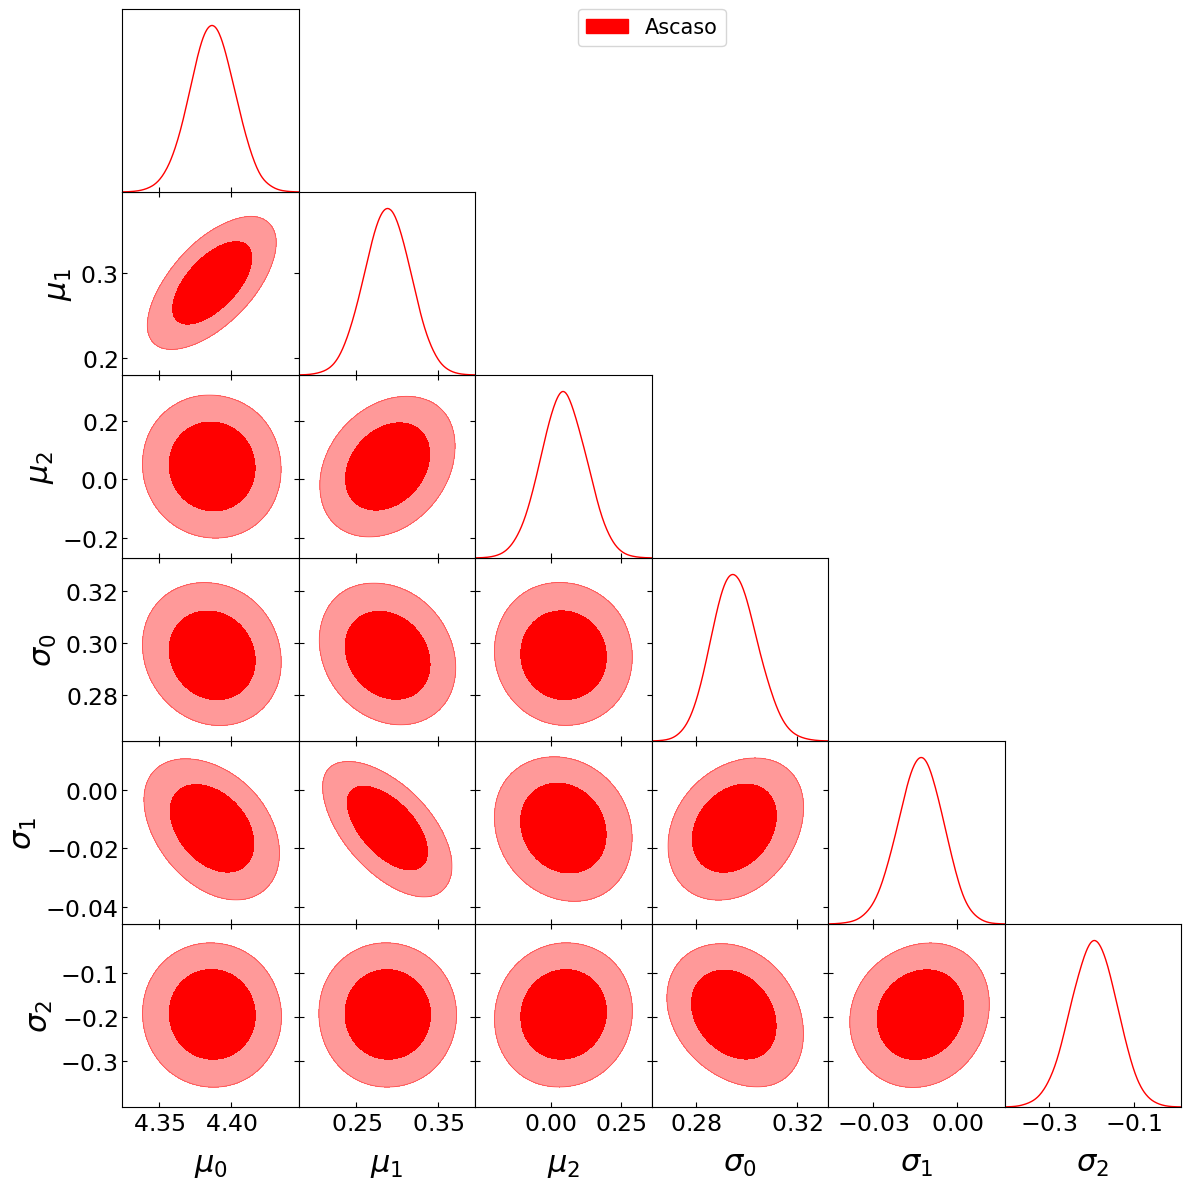

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [15]:
# Triangle plot
g1 = plots.get_subplot_plotter()

g1.settings.legend_fontsize = 18
g1.settings.lab_fontsize = 25
g1.settings.axes_fontsize = 20


g1.triangle_plot(
    [samples1],
    filled=True,
    contour_ls="-",
    contour_lws=1,
    fontsize=14,
    fine_bins=1,
    colors=['red'],
    line_args=[{'lw':1.2,'ls':'-', 'color':'red'}],
    legend_labels=["Ascaso"],
)

plt.show()
for i in range(1, 7):
    display(Math(samples1.getInlineLatex(str(i),limit=1)))
# plt.savefig('mcmc3.png')



In [16]:
data_fit_full = pd.DataFrame(fits.open("richness_cut/"+MODEL+"_rmin_"+str(RICH_CUT)+".fits")[1].data).iloc[:, 1:13].T
data_fit_void = np.array(data_fit_full)
data_fit = []
for item in data_fit_void:
    arr= np.array(item)
    data_fit.append(np.asarray(arr.tolist()))

names = [
    '1',
    '2',
    '3',
    '4',
    '5',
    '6',
    '7',
    '8',
    '9',
    '10',
    '11',
    '12'
]
labels=["\mu_0", "\mu_{M1}", "\mu_{M2}", "\mu_{Z1}"," \mu_{Z2}", "\mu_{MZ}", "\sigma_0", "\sigma_{M1}", "\sigma_{M2}", "\sigma_{Z1}", "\sigma_{Z2}", "\sigma_{MZ}" ]
settings = {
    "mult_bias_correction_order": 0,
    "smooth_scale_2D": 3,
    "smooth_scale_1D": 3,
    "boundary_correction_order": 0,
}
samples2 = MCSamples(samples=data_fit, names=names, labels=labels, settings=settings)
samples2.removeBurn(0.3)


Removed no burn in


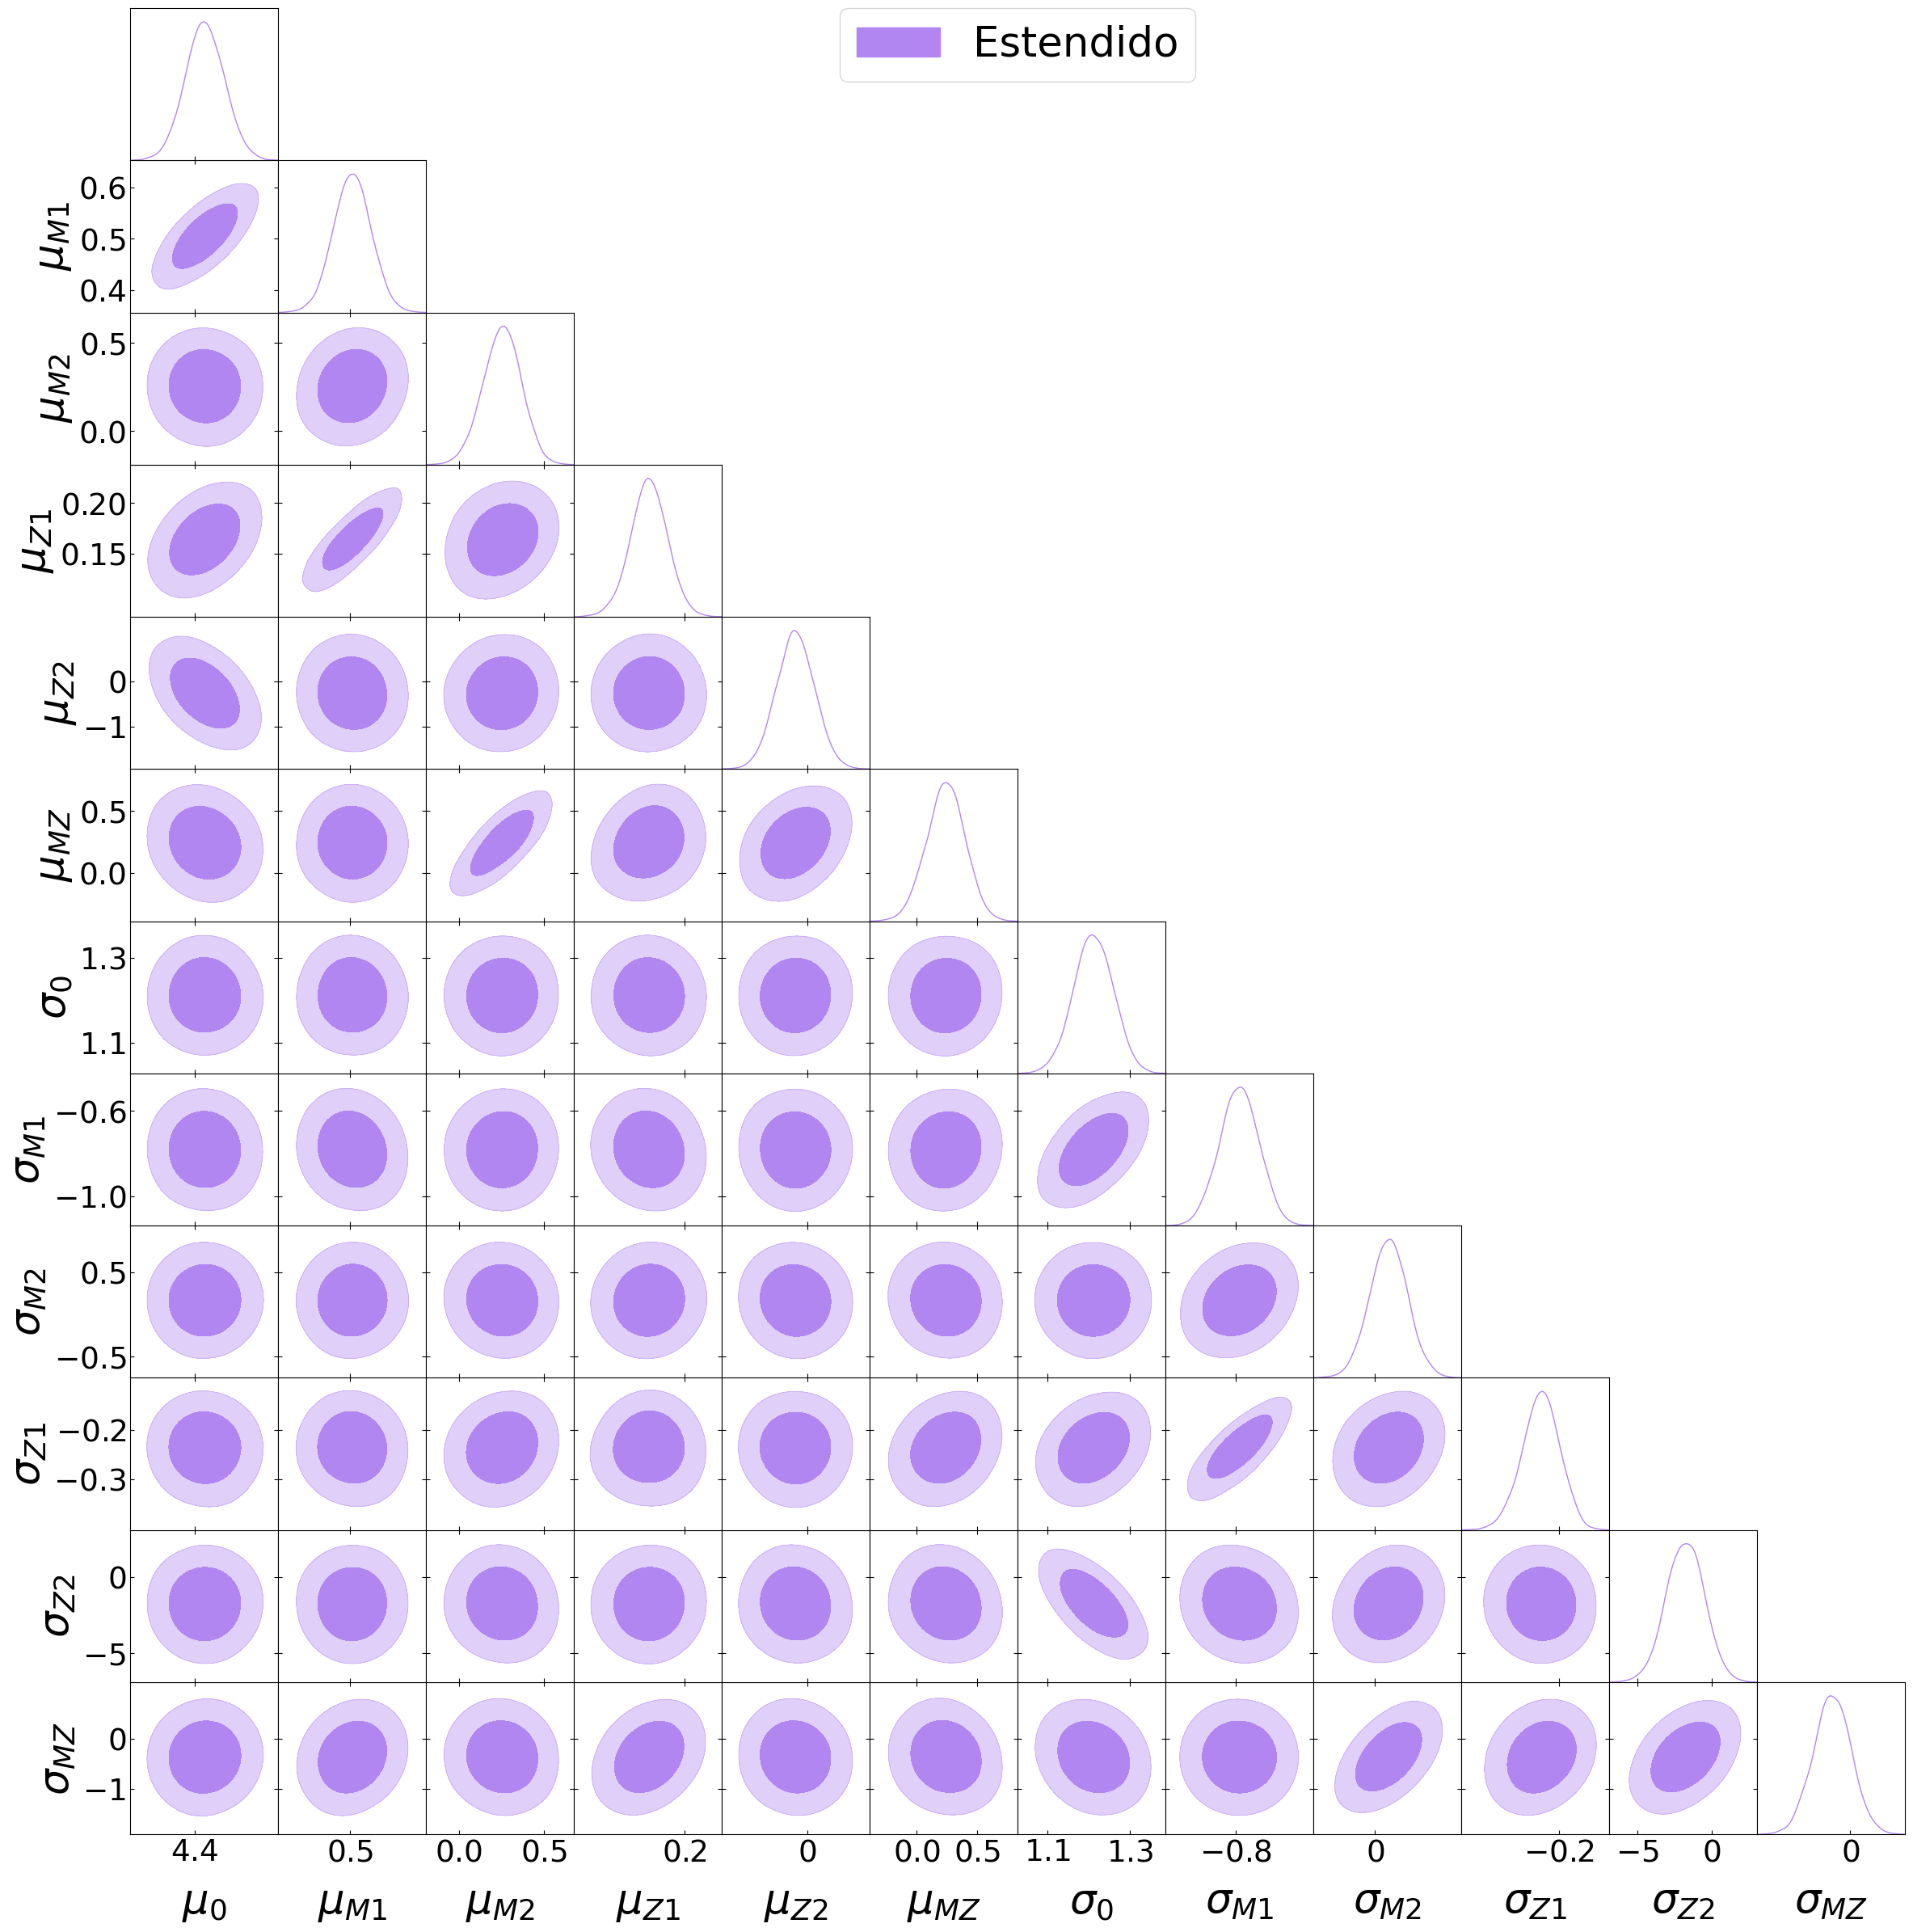

In [17]:
# Triangle plot
g2 = plots.get_subplot_plotter()

g2.settings.lab_fontsize = 40
g2.settings.legend_fontsize = 40
g2.settings.axes_fontsize = 30

g2.triangle_plot(
    [samples2],
    filled=True,
    contour_ls="-",
    contour_lws=1,
    fine_bins=1,
    colors=['#b186f1'],
    fontsize=70,
    line_args=[{'lw':1.2,'ls':'-', 'color':'#b186f1'}],
    legend_labels=["Estendido", ],
)
#plt.savefig('mcmc.png')
plt.show()


In [18]:
for i in range(1, 13):
    display(Math(samples2.getInlineLatex(str(i),limit=1)))


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>